In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.typing import NDArray, ArrayLike
from typing import List, Tuple

# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html#sklearn.linear_model.Ridge
from sklearn.linear_model import Ridge, LinearRegression

from scipy.interpolate import interp1d


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


## Single point thresholds

In [2]:
signal_levels = 10**np.arange(-3, 0.51, .25)
default_noise_level = 1.2

correlation_trial_count_list = [1, 2, 10]
correlation_trial_count_list = np.asarray(sorted(list(set([int(f) for f in 10**np.arange(0, 4.1, 0.25)]))))

spc_threshold = 1 # What d' do we want for threshold?
spp_threshold = 1 # What d' do we want for threshold?
spjk_threshold = 1 # What d' do we want for threshold?
spml_threshold = 1 # Threshold for multi-look tests

correlation_trial_count_list

array([    1,     3,     5,    10,    17,    31,    56,   100,   177,
         316,   562,  1000,  1778,  3162,  5623, 10000])

In [3]:
a=list(range(5))
a

[0, 1, 2, 3, 4]

In [4]:
def jackknife_correlate(data):
    """Compute the correlation of the data with a model that does *not* include
    the trial data. 

    Args:
        data: measurements of size num_trials x num_experiments
    Returns
        Array of size num_trials x num_experiments
    """
    results = np.zeros(data.shape)
    for i in range(data.shape[0]):
        other_data = np.concatenate((data[:i, :], data[i+1:, :]), axis=0)
        model = np.mean(other_data, axis=0)
        results[i, :] = data[i, :] * model
    return results

In [5]:
def simulate_point_process(n: float = 1.2, num_experiments: int = 1000, jackknife: bool = False):
    """Generate simulated single-point ABR data and measure it's correlation and power metrics.
    Use the same data for both approaches to maximize commonality.

    Args:
        n: the amplitude of the noise (standard deviation of a Gaussian)
        num_experiments: How many experiments, each with multiple trials, to run
        jackknife: Whether to use jackkniving to build each model from data we don't use for testing

    Returns:
        spc_dprimes: Estimated d' for the single-point correlation measure
        spp_dprimes: Estimated d' for the single-point power measure
        spc_mean_noise: The mean, per experiment, of the correlation measure of the noise (no signal)
        spc_mean_signal: The mean, per experiment, of the correlation measure of the signal
        spc_var_noise: The variance, across experiments, of the correlation measure of the noise (no signal)
        spc_var_signal: The variance, across experiments, of the correlation measure of the signal
        spp_mean_noise: The mean, per experiment, of the power measure of the noise (no signal)
        spp_mean_signal: The mean, per experiment, of the power measure of the signal
        spp_var_noise: The variance, across experiments, of the power measure of the noise (no signal)
        spp_var_signal: The variance, across experiments, of the power measure of the signal
    """
    num_experiments = 1000
    spc_dprimes = np.zeros((len(signal_levels), len(correlation_trial_count_list)))  # Single Point Correlation d'
    spp_dprimes = spc_dprimes.copy()  # Single Point Power d'
    
    spp_mean_signal = spp_dprimes.copy()
    spp_mean_noise = spp_dprimes.copy()
    spp_var_signal = spp_dprimes.copy()
    spp_var_noise = spp_dprimes.copy()
    spc_mean_signal = spp_dprimes.copy()
    spc_mean_noise = spp_dprimes.copy()
    spc_var_signal = spp_dprimes.copy()
    spc_var_noise = spp_dprimes.copy()
    
    # Estimate measures over different signal levels and number of trials.
    for i, s in enumerate(signal_levels):
      for j, trial_count in enumerate(correlation_trial_count_list):
        measurements = n*np.random.randn(trial_count, num_experiments) + s  # The measured ABR signals
        # Must get new noise for the no-signal measurement.
        noise = n*np.random.randn(trial_count, num_experiments)

        # Now compute the correlations against the model, average across trials.
        if jackknife == False:
            signal_model = np.mean(measurements, axis=0, keepdims=True)
            noise_model = np.mean(noise, axis=0, keepdims=True)
            noise_correlations = noise * noise_model
            signal_correlations = measurements * signal_model
        else:
            noise_correlations = jackknife_correlate(noise)
            signal_correlations = jackknife_correlate(measurements)
        assert signal_correlations.shape == noise_correlations.shape == (trial_count, num_experiments)
    
        # Now compute RMS over each group of looks.
        # noise_distances = np.sqrt(np.mean(noise_correlations ** 2, axis=0))
        # signal_distances = np.sqrt(np.mean(signal_correlations ** 2, axis=0))
        # assert signal_distances.shape == (num_experiments,)
    
        # Compute d' across all the trials and all the experiments.
        spc_mean_noise[i, j] = np.mean(noise_correlations)
        spc_mean_signal[i, j] = np.mean(signal_correlations)
        spc_var_noise[i, j] = np.var(noise_correlations)
        spc_var_signal[i, j] = np.var(signal_correlations)
        spc_dprimes[i, j] = (spc_mean_signal[i, j] - spc_mean_noise[i, j])/(
                    np.sqrt((spc_var_signal[i, j] + spc_var_noise[i, j])/2))
    
        # Now measure power stats for the same data.
        ave_signal = np.mean(measurements, axis=0)**2
        ave_noise = np.mean(noise, axis=0)**2
        spp_mean_noise[i, j] = np.mean(ave_noise)
        spp_mean_signal[i, j] = np.mean(ave_signal)
        spp_var_noise[i, j] = np.var(ave_noise)
        spp_var_signal[i, j] = np.var(ave_signal)
        spp_dprimes[i, j] = (spp_mean_signal[i, j] - spp_mean_noise[i, j])/(
                    np.sqrt((spp_var_signal[i, j] + spp_var_noise[i, j])/2))
    return (spc_dprimes, spp_dprimes, 
            spc_mean_noise, spc_mean_signal, spc_var_noise, spc_var_signal,
            spp_mean_noise, spp_mean_signal, spp_var_noise, spp_var_signal)

### Correlation and Power

In [6]:
# spc is single point correlation
# spp is single point power metric
# spjk is single point correlation via jackknife

(spc_dprimes, spp_dprimes, 
 spc_mean_noise, spc_mean_signal, spc_var_noise, spc_var_signal,
 spp_mean_noise, spp_mean_signal, spp_var_noise, spp_var_signal) = simulate_point_process(n=default_noise_level)

In [7]:
s = np.asarray(signal_levels).reshape((1, -1))
n = default_noise_level
N = np.asarray(correlation_trial_count_list).reshape((-1, 1))
spc_dprimes_theory = (np.sqrt(2)*N*s*s/(n*np.sqrt(N*N*s*s + 3*N*s*s + 2*N*n*n + 2*n*n))).T
spc_dprimes.shape, spc_dprimes_theory.shape
# Num signal levels x Num trials counts

((15, 16), (15, 16))

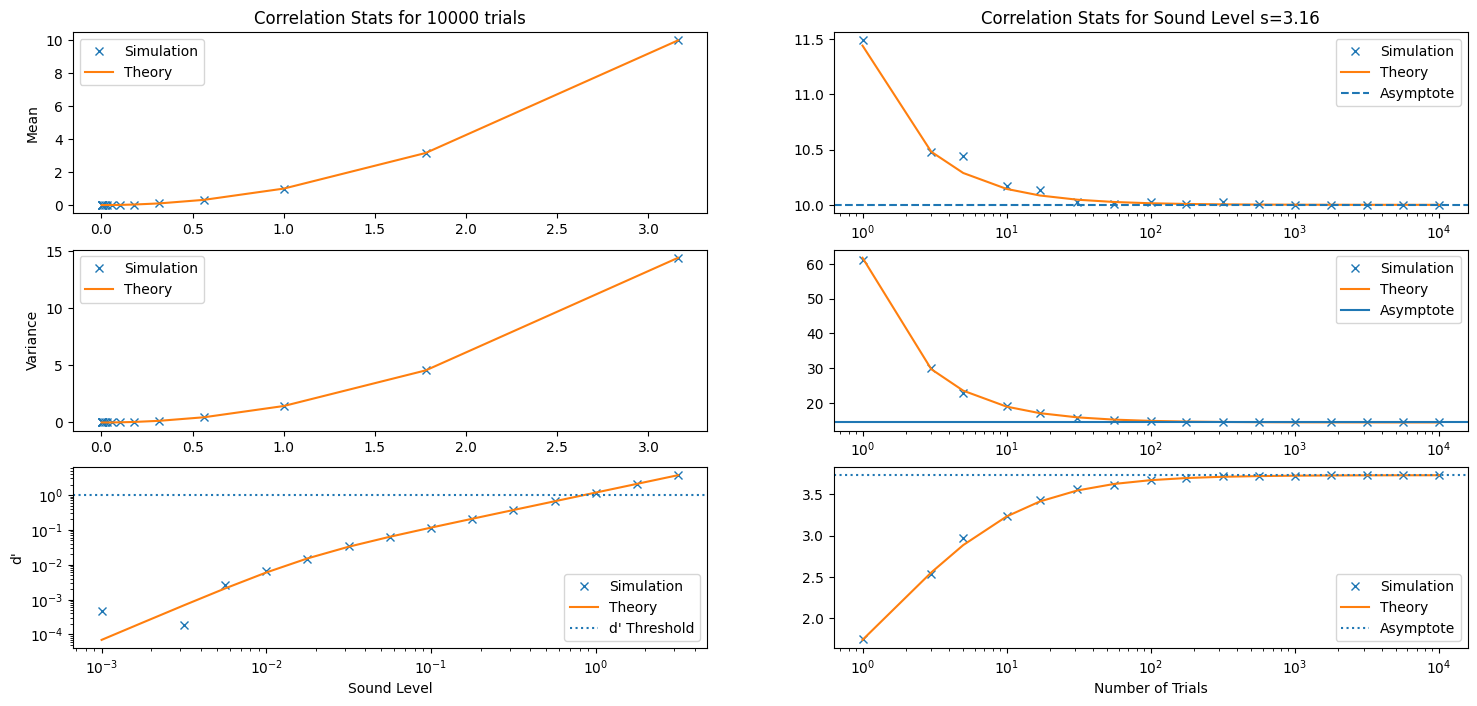

In [210]:
n = default_noise_level

plt.figure(figsize=(18, 8))

plt.subplot(3, 2, 1)
plt.plot(signal_levels, np.asarray(spc_mean_signal)[:, -1], 'x', label='Simulation')
s = np.asarray(signal_levels)
d = spc_threshold
N = correlation_trial_count_list[-1]
plt.plot(signal_levels, s*s + n*n/N, label='Theory')
plt.title(f'Correlation Stats for {N} trials')
plt.ylabel('Mean')
plt.legend()

plt.subplot(3, 2, 2);
plt.semilogx(correlation_trial_count_list, np.asarray(spc_mean_signal)[-1, :], 'x', label='Simulation')
s = np.asarray(signal_levels)[-1]
d = spc_threshold
N = correlation_trial_count_list
plt.semilogx(N, s*s + n*n/N, label='Theory')
plt.axhline(s*s, ls='--', label='Asymptote')
plt.title(f'Correlation Stats for Sound Level s={s:4.2f}');
plt.legend()

##################### Now plot the Variances  #####################
plt.subplot(3, 2, 3)
plt.plot(signal_levels, np.asarray(spc_var_signal)[:, -1], 'x', label='Simulation')
s = np.asarray(signal_levels)
d = spc_threshold
N = correlation_trial_count_list[-1]
plt.plot(signal_levels, s*s*n*n*(1+3/N)+(N+1)*n**4/N**2, label='Theory')
plt.ylabel('Variance')
plt.legend()

plt.subplot(3, 2, 4);
plt.semilogx(correlation_trial_count_list, np.asarray(spc_var_signal)[-1, :], 'x', label='Simulation')
s = np.asarray(signal_levels)[-1]
d = spc_threshold
N = correlation_trial_count_list
plt.semilogx(N, s*s*n*n*(1+3/N)+(N+1)*n**4/N**2, label='Theory')
plt.axhline(s*s*n*n, label='Asymptote')
plt.legend()

##################### Now plot the d's #####################
plt.subplot(3, 2, 5) # Plot by signal level
plt.loglog(signal_levels, np.asarray(spc_dprimes)[:, -1], 'x', label='Simulation')
s = np.asarray(signal_levels)
n = default_noise_level  # Implicit definition used in the code above
d = spc_threshold
N = correlation_trial_count_list[-1]
dprimes = np.sqrt(2)*N*s**2/n/np.sqrt(N**2*s**2 + 3*N*s**2 + 2*N*n**2 + 2*n**2)
plt.loglog(signal_levels, dprimes, label='Theory')
# plt.plot(signal_levels, np.sqrt(2)*s/n, ls=':', label='Asymptote')
plt.axhline(spc_threshold, ls=':', label='d\' Threshold')
plt.legend()
plt.xlabel('Sound Level')
plt.ylabel('d\'')

plt.subplot(3, 2, 6)  # Plot by trial count
plt.semilogx(correlation_trial_count_list, np.asarray(spc_dprimes)[-1, :], 'x', label='Simulation')
s = np.asarray(signal_levels)[-1]
n = default_noise_level  # Implicit definition used in the code above
d = spc_threshold
N = correlation_trial_count_list
dprimes = np.sqrt(2)*N*s**2/n/np.sqrt(N**2*s**2 + 3*N*s**2 + 2*N*n**2 + 2*n**2)
plt.semilogx(N, dprimes, label='Theory')
plt.axhline(np.sqrt(2)*s/n, ls=':', label='Asymptote')
plt.legend();
plt.xlabel('Number of Trials');

plt.savefig('SinglePointCorrelationStats.png')

Signal level at which d' crosses the threshold=1 by trial count:
Trial count 1: 1.9260
Trial count 3: 1.5099
Trial count 5: 1.2150
Trial count 10: 1.0384
Trial count 17: 0.9710
Trial count 31: 0.9128
Trial count 56: 0.9027
Trial count 100: 0.8747
Trial count 177: 0.8599
Trial count 316: 0.8568
Trial count 562: 0.8554
Trial count 1000: 0.8502
Trial count 1778: 0.8492
Trial count 3162: 0.8496
Trial count 5623: 0.8494
Trial count 10000: 0.8485


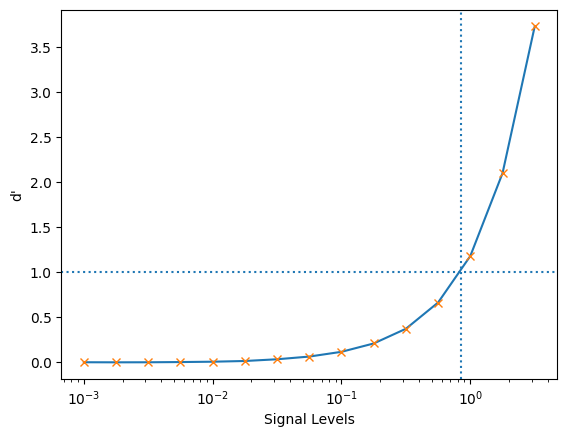

In [9]:
# Now find the sound level that gives the desired power threshold for the correlation measure.
spc_interpolated = []

for j in range(spc_dprimes.shape[1]):  # For each trial count
  # Create an interpolation function for the current trial count's dprimes
  interp_func = interp1d(spc_dprimes[:, j], signal_levels, kind='quadratic')

  # Find the signal level at the threshold using the interpolation function
  try:
    spc_interpolated.append(interp_func(spc_threshold))
  except ValueError:
    # If the threshold is outside the range of dprimes, append NaN
    spc_interpolated.append(np.nan)
if True:
      plt.semilogx(signal_levels, spc_dprimes[:, j])
      plt.semilogx(signal_levels, spc_dprimes[:, j], 'x')
      plt.axhline(spc_threshold, ls=':')
      plt.axvline(spc_interpolated[-1], ls=':')
      plt.xlabel('Signal Levels')
      plt.ylabel('d\'')

print(f"Signal level at which d' crosses the threshold={spc_threshold} by trial count:")
for j, trial_count in enumerate(correlation_trial_count_list):
  print(f"Trial count {trial_count}: {spc_interpolated[j]:.4f}")

In [10]:
n = default_noise_level # Implicit definition used in the code above
d = spc_threshold
N = correlation_trial_count_list

spc_theory = n*np.sqrt(d)/2/np.sqrt(N)*np.sqrt(d*(N+3)+np.sqrt(d*d*(N*N + 6*N + 9) + 16*N + 16))

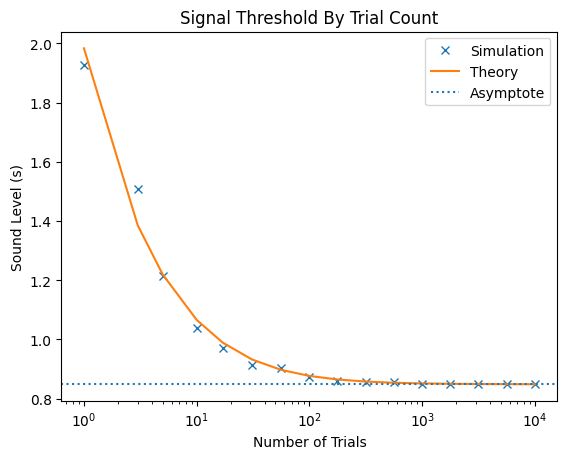

In [183]:
##################### Now plot the thresholds #####################
plt.semilogx(correlation_trial_count_list, np.asarray(spc_interpolated), 'x', label='Simulation')
s = np.asarray(signal_levels)[-1]
n = default_noise_level # Implicit definition used in the code above
d = spc_threshold
N = correlation_trial_count_list
plt.semilogx(N, spc_theory, label='Theory')
plt.axhline(d*n/np.sqrt(2), ls=':', label='Asymptote')
plt.title(f'Signal Threshold By Trial Count');
plt.xlabel('Number of Trials')
plt.ylabel('Sound Level (s)')
plt.legend();

plt.savefig('SinglePointCorrelationThreshold.png')

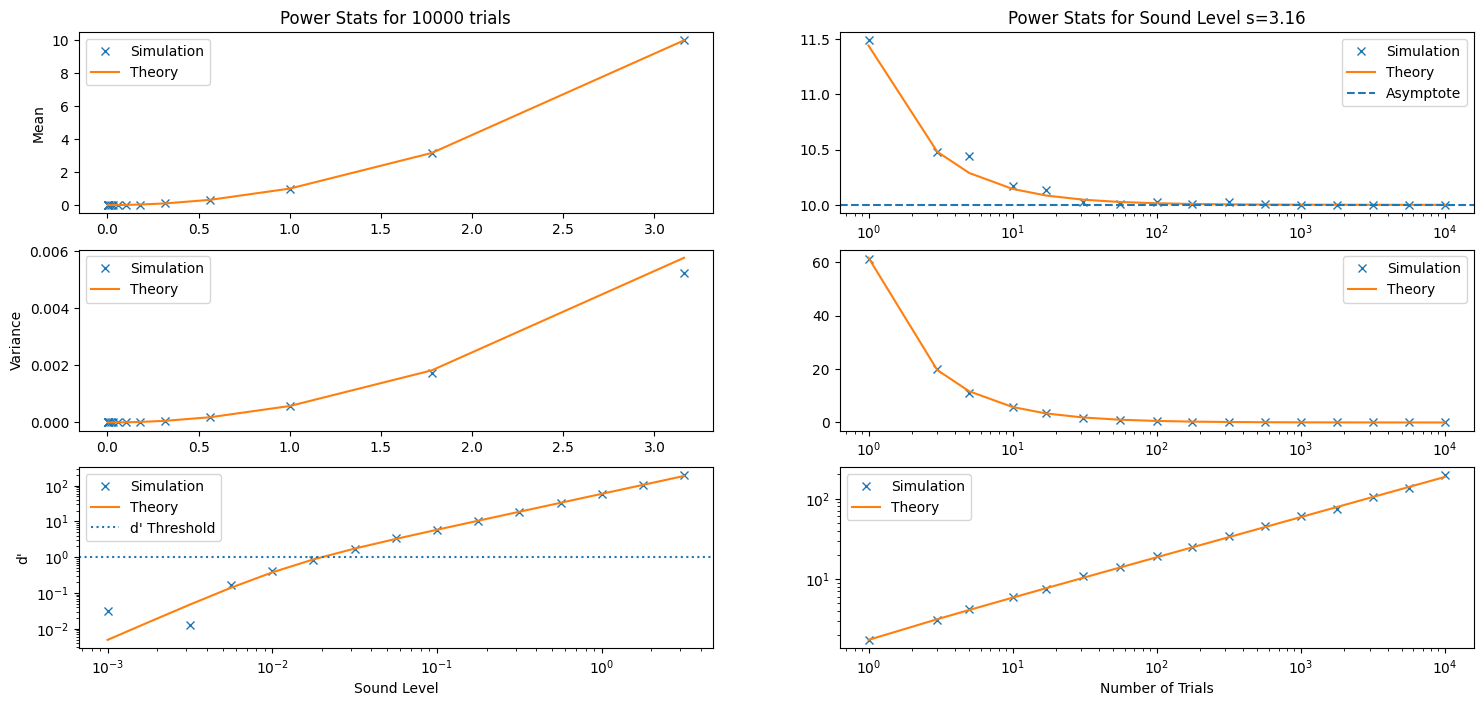

In [208]:
plt.figure(figsize=(18, 8))

plt.subplot(3, 2, 1)
plt.plot(signal_levels, np.asarray(spp_mean_signal)[:, -1], 'x', label='Simulation')
s = np.asarray(signal_levels)
n = default_noise_level # Implicit definition used in the code above
d = spc_threshold
N = correlation_trial_count_list[-1]
plt.plot(signal_levels, s*s + n*n/N, label='Theory')
plt.title(f'Power Stats for {N} trials')
plt.ylabel('Mean')
plt.legend()

plt.subplot(3, 2, 2);
plt.semilogx(correlation_trial_count_list, np.asarray(spp_mean_signal)[-1, :], 'x', label='Simulation')
s = np.asarray(signal_levels)[-1]
n = default_noise_level # Implicit definition used in the code above
d = spc_threshold
N = correlation_trial_count_list
plt.semilogx(N, s*s + n*n/N, label='Theory')
plt.axhline(s*s, ls='--', label='Asymptote')
plt.title(f'Power Stats for Sound Level s={s:4.2f}');
plt.legend()

##################### Now plot the Variances  #####################
plt.subplot(3, 2, 3)
plt.plot(signal_levels, np.asarray(spp_var_signal)[:, -1], 'x', label='Simulation')
s = np.asarray(signal_levels)
n = default_noise_level # Implicit definition used in the code above
d = spc_threshold
N = correlation_trial_count_list[-1]
plt.plot(signal_levels, 4*s*s*n*n/N+2*n**4/N**2, label='Theory')
plt.ylabel('Variance')
plt.legend()

plt.subplot(3, 2, 4);
plt.semilogx(correlation_trial_count_list, np.asarray(spp_var_signal)[-1, :], 'x', label='Simulation')
s = np.asarray(signal_levels)[-1]
n = default_noise_level # Implicit definition used in the code above
d = spc_threshold
N = correlation_trial_count_list
plt.semilogx(N, 4*s*s*n*n/N+2*n**4/N**2, label='Theory')
plt.legend()

##################### Now plot the d's #####################
plt.subplot(3, 2, 5) # Plot by signal level
plt.loglog(signal_levels, np.asarray(spp_dprimes)[:, -1], 'x', label='Simulation')
s = np.asarray(signal_levels)
n = default_noise_level # Implicit definition used in the code above
d = spc_threshold
N = correlation_trial_count_list[-1]
dprimes = s*s/np.sqrt(2*s*s*n*n/N + 2*n**4/N**2)
plt.loglog(signal_levels, dprimes, label='Theory')
# plt.plot(signal_levels, np.sqrt(2)*s/n, ls=':', label='Asymptote')
plt.axhline(spp_threshold, ls=':', label='d\' Threshold')
plt.legend()
plt.xlabel('Sound Level')
plt.ylabel('d\'')

plt.subplot(3, 2, 6)  # Plot by trial count
plt.loglog(correlation_trial_count_list, np.asarray(spp_dprimes)[-1, :], 'x', label='Simulation')
s = np.asarray(signal_levels)[-1]
n = default_noise_level  # Implicit definition used in the code above
d = spp_threshold
N = correlation_trial_count_list
dprimes = s*s/np.sqrt(2*s*s*n*n/N + 2*n**4/N**2)
plt.loglog(N, dprimes, label='Theory')
# plt.axhline(np.sqrt(2)*s/n, ls=':', label='Asymptote')
plt.legend();
plt.xlabel('Number of Trials');

plt.savefig('SinglePointPowerStats.png')

In [13]:
spp_interpolated = []

for j in range(spc_dprimes.shape[1]):   # For each trial count
  # Create an interpolation function for the current trial count's dprimes
  interp_func = interp1d(spp_dprimes[:, j], signal_levels, kind='linear')

  # Find the signal level at the threshold using the interpolation function
  try:
    spp_interpolated.append(interp_func(spp_threshold))
  except ValueError:
    # If the threshold is outside the range of dprimes, append NaN
    spp_interpolated.append(np.nan)


print(f"Signal level at which d' crosses the threshold (d'={spp_threshold}) for each trial count spc_interpolated:")
for j, trial_count in enumerate(correlation_trial_count_list):
  print(f"Trial count {trial_count}: {spp_interpolated[j]:.4f}")

Signal level at which d' crosses the threshold (d'=1) for each trial count spc_interpolated:
Trial count 1: 1.9831
Trial count 3: 1.1890
Trial count 5: 0.8185
Trial count 10: 0.6357
Trial count 17: 0.4796
Trial count 31: 0.3574
Trial count 56: 0.2690
Trial count 100: 0.1977
Trial count 177: 0.1486
Trial count 316: 0.1098
Trial count 562: 0.0821
Trial count 1000: 0.0624
Trial count 1778: 0.0462
Trial count 3162: 0.0348
Trial count 5623: 0.0276
Trial count 10000: 0.0205


In [14]:
n = default_noise_level  # Implicit definition used in the code above
d = spp_threshold
N = correlation_trial_count_list

spp_theory = n*np.sqrt(d/N*(d+np.sqrt(d*d+2)))

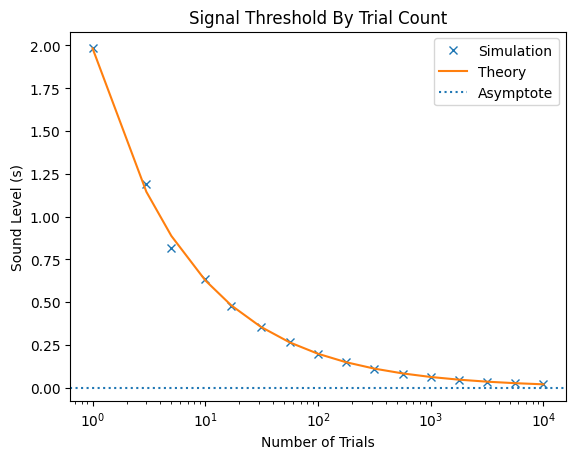

In [184]:
##################### Now plot the thresholds #####################
plt.semilogx(correlation_trial_count_list, np.asarray(spp_interpolated), 'x', label='Simulation')
s = np.asarray(signal_levels)[-1]
n = default_noise_level  # Implicit definition used in the code above
d = spp_threshold
N = correlation_trial_count_list
plt.semilogx(N, spp_theory, label='Theory')
plt.axhline(0, ls=':', label='Asymptote')
plt.title(f'Signal Threshold By Trial Count');
plt.xlabel('Number of Trials')
plt.ylabel('Sound Level (s)')
plt.legend();

plt.savefig('SinglePointPowerThreshold.png')

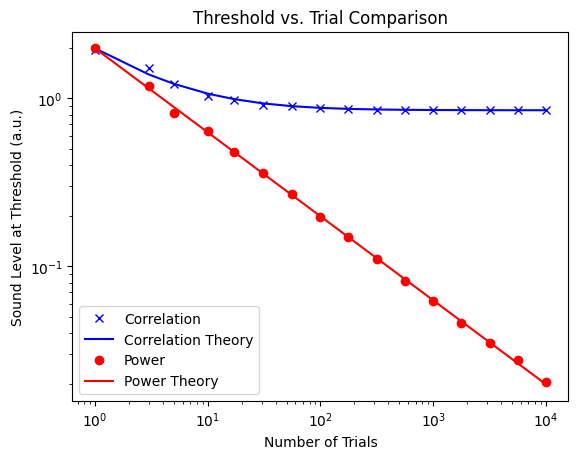

In [186]:
plt.loglog(correlation_trial_count_list, spc_interpolated, 'bx', label='Correlation')
plt.loglog(correlation_trial_count_list, spc_theory, 'b', label='Correlation Theory')
plt.loglog(correlation_trial_count_list, spp_interpolated, 'ro', label='Power')
plt.loglog(correlation_trial_count_list, spp_theory, 'r', label='Power Theory')
plt.xlabel('Number of Trials')
plt.ylabel('Sound Level at Threshold (a.u.)')
plt.title(f'Threshold vs. Trial Comparison')
# plt.plot(correlation_trial_count_list, 2*correlation_trial_count_list**(-0.5), '--', label='$\\sqrt{N}$');
# plt.plot(correlation_trial_count_list, 2*correlation_trial_count_list**(-0.25), '--', label='$N**{-0.25}$');
plt.legend();

plt.savefig('SinglePointThresholdComparison.png')

### Jackknife Test

In [17]:
(spjk_dprimes, _, 
 spjk_mean_noise, spjk_mean_signal, spjk_var_noise, spjk_var_signal,
 _, _, _, _) = simulate_point_process(n=default_noise_level, jackknife=True)

/Users/malcolm/anaconda3/envs/audiology/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/malcolm/anaconda3/envs/audiology/lib/python3.12/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


/var/folders/5j/rxjx24r101l4rnlgykg939pr0000gn/T/ipykernel_3641/2720653432.py:41: RuntimeWarning: divide by zero encountered in divide
  plt.semilogx(N, s*s*n*n*(1+1/(N-1))+n**4/(N-1), label='Theory')
/var/folders/5j/rxjx24r101l4rnlgykg939pr0000gn/T/ipykernel_3641/2720653432.py:65: RuntimeWarning: divide by zero encountered in divide
  dprimes = s*s/(n*np.sqrt(s*s*(1+1/(N-1))/2 + n*n/(N-1)))


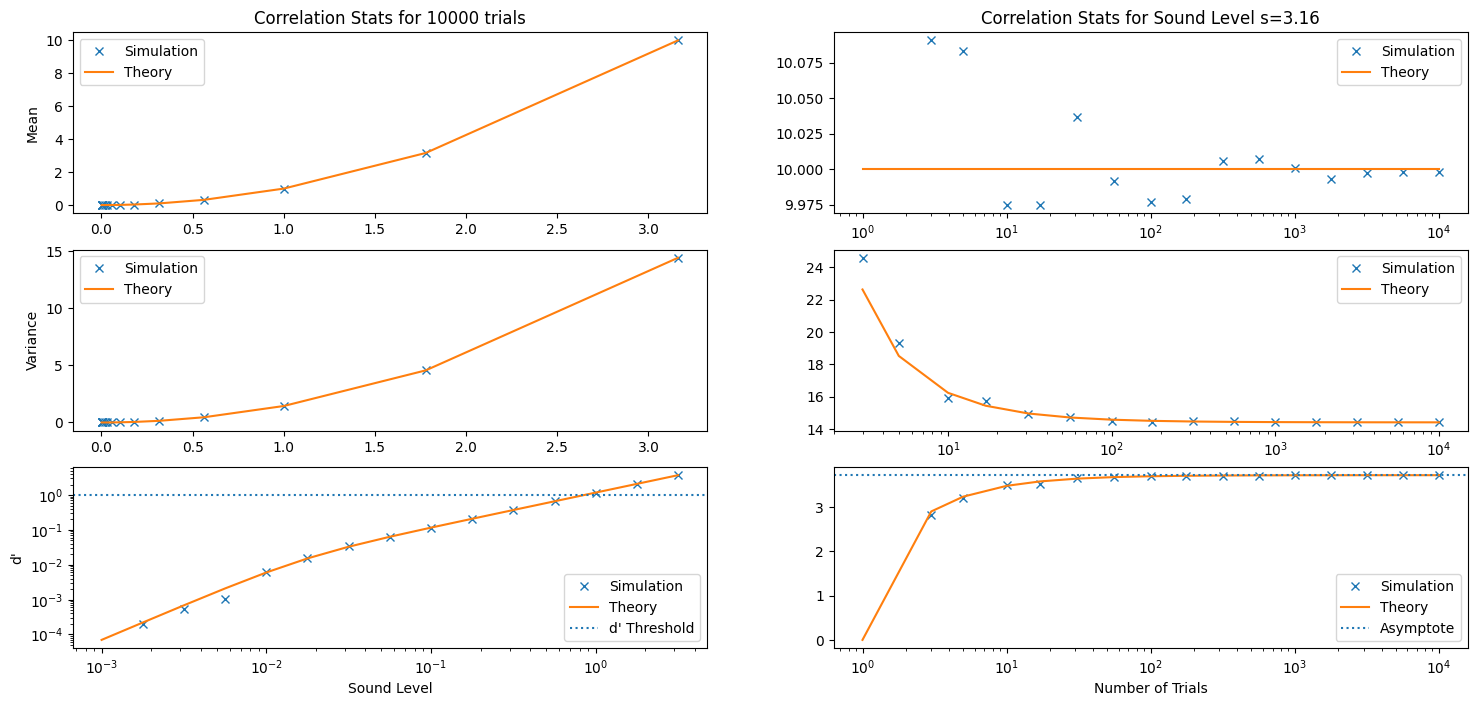

In [212]:
plt.figure(figsize=(18, 8))

plt.subplot(3, 2, 1)
plt.plot(signal_levels, np.asarray(spjk_mean_signal)[:, -1], 'x', label='Simulation')
s = np.asarray(signal_levels)
n = default_noise_level  # Implicit definition used in the code above
d = spc_threshold
N = correlation_trial_count_list[-1]
plt.plot(signal_levels, s*s, label='Theory')
plt.title(f'Correlation Stats for {N} trials')
plt.ylabel('Mean')
plt.legend()

plt.subplot(3, 2, 2);
plt.semilogx(correlation_trial_count_list, np.asarray(spjk_mean_signal)[-1, :], 'x', label='Simulation')
s = np.asarray(signal_levels)[-1]
n = default_noise_level  # Implicit definition used in the code above
d = spc_threshold
N = correlation_trial_count_list
plt.semilogx(N, s*s+0*correlation_trial_count_list, label='Theory')
plt.title(f'Correlation Stats for Sound Level s={s:4.2f}');
plt.legend()

##################### Now plot the Variances  #####################
plt.subplot(3, 2, 3)
plt.plot(signal_levels, np.asarray(spjk_var_signal)[:, -1], 'x', label='Simulation')
s = np.asarray(signal_levels)
n = default_noise_level  # Implicit definition used in the code above
d = spc_threshold
N = correlation_trial_count_list[-1]
plt.plot(signal_levels, s*s*n*n*(1+1/(N-1))+n**4/(N-1), label='Theory')
plt.ylabel('Variance')
plt.legend()

plt.subplot(3, 2, 4);
plt.semilogx(correlation_trial_count_list, np.asarray(spjk_var_signal)[-1, :], 'x', label='Simulation')
s = np.asarray(signal_levels)[-1]
n = default_noise_level  # Implicit definition used in the code above
d = spc_threshold
N = correlation_trial_count_list
plt.semilogx(N, s*s*n*n*(1+1/(N-1))+n**4/(N-1), label='Theory')
plt.legend()

##################### Now plot the d's #####################
plt.subplot(3, 2, 5) # Plot by signal level
plt.loglog(signal_levels, np.asarray(spjk_dprimes)[:, -1], 'x', label='Simulation')
s = np.asarray(signal_levels)
n = default_noise_level # Implicit definition used in the code above
d = spc_threshold
N = correlation_trial_count_list[-1]
dprimes = s*s/(n*np.sqrt(s*s*(1+1/(N-1))/2 + n*n/(N-1)))
plt.loglog(signal_levels, dprimes, label='Theory')
# plt.plot(signal_levels, np.sqrt(2)*s/n, ls=':', label='Asymptote')
plt.axhline(spc_threshold, ls=':', label='d\' Threshold')
plt.legend()
plt.xlabel('Sound Level')
plt.ylabel('d\'')

plt.subplot(3, 2, 6)  # Plot by trial count
plt.semilogx(correlation_trial_count_list, np.asarray(spjk_dprimes)[-1, :], 'x', label='Simulation')
s = np.asarray(signal_levels)[-1]
n = default_noise_level  # Implicit definition used in the code above
d = spc_threshold
N = correlation_trial_count_list
dprimes = s*s/(n*np.sqrt(s*s*(1+1/(N-1))/2 + n*n/(N-1)))
plt.semilogx(N, dprimes, label='Theory')
plt.axhline(np.sqrt(2)*s/n, ls=':', label='Asymptote')
plt.legend();
plt.xlabel('Number of Trials');

plt.savefig('SinglePointJackknifeStats.png')

In [19]:
spjk_interpolated = []

for j in range(spjk_dprimes.shape[1]):   # For each trial count
  # Create an interpolation function for the current trial count's dprimes
  interp_func = interp1d(spjk_dprimes[:, j], signal_levels, kind='linear')

  # Find the signal level at the threshold using the interpolation function
  try:
    spjk_interpolated.append(interp_func(spjk_threshold))
  except ValueError:
    # If the threshold is outside the range of dprimes, append NaN
    spjk_interpolated.append(np.nan)


print(f"Signal level at which d' crosses the threshold (d'={spjk_threshold}) for each trial count spc_interpolated:")
for j, trial_count in enumerate(correlation_trial_count_list):
  print(f"Trial count {trial_count}: {spjk_interpolated[j]:.4f}")

Signal level at which d' crosses the threshold (d'=1) for each trial count spc_interpolated:
Trial count 1: nan
Trial count 3: 1.2793
Trial count 5: 1.1444
Trial count 10: 1.0080
Trial count 17: 0.9461
Trial count 31: 0.9168
Trial count 56: 0.8925
Trial count 100: 0.8721
Trial count 177: 0.8628
Trial count 316: 0.8556
Trial count 562: 0.8534
Trial count 1000: 0.8498
Trial count 1778: 0.8507
Trial count 3162: 0.8494
Trial count 5623: 0.8488
Trial count 10000: 0.8488


In [20]:
n = default_noise_level  # Implicit definition used in the code above
d = spjk_threshold
N =  np.asarray(correlation_trial_count_list).astype(float)

spjk_theory = n*np.sqrt((d*(d*N+np.sqrt(d*d*N*N+8*N-8)))/(2*(N-1))) # Eq. 113 - WRONG
spjk_theory = np.sqrt((d*n*n*(d*N+np.sqrt(d*d*N*N+16*N-16)))/(4*(N-1))) # Eq. 114

/var/folders/5j/rxjx24r101l4rnlgykg939pr0000gn/T/ipykernel_3641/404662526.py:5: RuntimeWarning: divide by zero encountered in divide
  spjk_theory = n*np.sqrt((d*(d*N+np.sqrt(d*d*N*N+8*N-8)))/(2*(N-1))) # Eq. 113 - WRONG
/var/folders/5j/rxjx24r101l4rnlgykg939pr0000gn/T/ipykernel_3641/404662526.py:6: RuntimeWarning: divide by zero encountered in divide
  spjk_theory = np.sqrt((d*n*n*(d*N+np.sqrt(d*d*N*N+16*N-16)))/(4*(N-1))) # Eq. 114


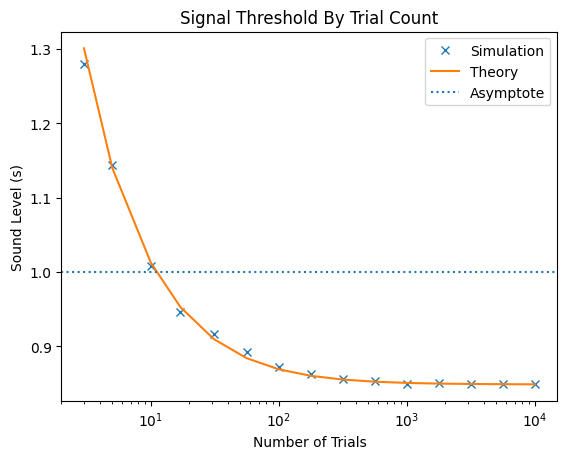

In [21]:
##################### Now plot the thresholds #####################
plt.semilogx(correlation_trial_count_list, np.asarray(spjk_interpolated), 'x', label='Simulation')
s = np.asarray(signal_levels)[-1]
n = default_noise_level  # Implicit definition used in the code above
d = spjk_threshold
N = correlation_trial_count_list
plt.semilogx(N, spjk_theory, label='Theory')
plt.axhline(spjk_threshold, ls=':', label='Asymptote')
plt.title(f'Signal Threshold By Trial Count');
plt.xlabel('Number of Trials')
plt.ylabel('Sound Level (s)')
plt.legend();

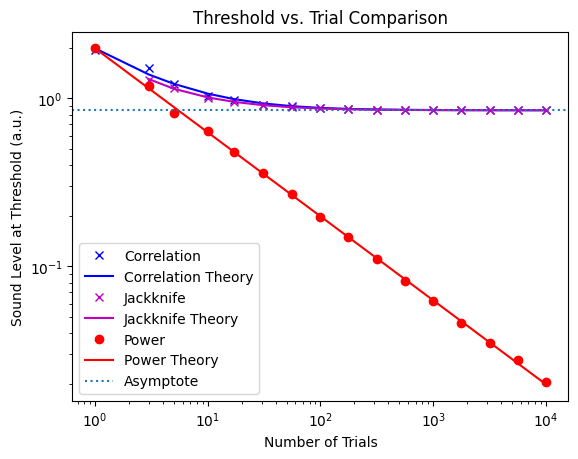

In [214]:
plt.loglog(correlation_trial_count_list, spc_interpolated, 'bx', label='Correlation')
plt.loglog(correlation_trial_count_list, spc_theory, 'b', label='Correlation Theory')
plt.loglog(correlation_trial_count_list, np.asarray(spjk_interpolated), 'mx', label='Jackknife')
plt.loglog(N, spjk_theory, 'm', label='Jackknife Theory')
plt.loglog(correlation_trial_count_list, spp_interpolated, 'ro', label='Power')
plt.loglog(correlation_trial_count_list, spp_theory, 'r', label='Power Theory')


plt.axhline(n/np.sqrt(2), ls=':', label='Asymptote')

plt.xlabel('Number of Trials')
plt.ylabel('Sound Level at Threshold (a.u.)')
plt.title(f'Threshold vs. Trial Comparison')
# plt.plot(correlation_trial_count_list, 2*correlation_trial_count_list**(-0.5), '--', label='$\\sqrt{N}$');
# plt.plot(correlation_trial_count_list, 2*correlation_trial_count_list**(-0.25), '--', label='$N**{-0.25}$');
plt.legend();

plt.savefig('SinglePointThresholdComparison.png')

### Multi-Look Correlation

In [164]:
def multi_look_process(signals, n: float = 1.2, 
                       num_experiments: int = 1000, theoretical_model: bool = False):
    """Generate simulated multi-point ABR data and measure it's correlation.

    Args:
        signals: An array-like set of signal values
        n: the amplitude of the noise (standard deviation of a Gaussian)
        num_experiments: How many experiments, each with multiple trials, to run
        jackknife: Whether to use jackkniving to build each model from data we don't use for testing

    Returns:
        All returned arrays are of size num_signal_levels x num_trials
        
        spml_dprimes: Estimated d' for the single-point correlation measure
        spml_mean_noise: The mean, per experiment, of the correlation measure of the noise (no signal)
        spml_mean_signal: The mean, per experiment, of the correlation measure of the signal
        spml_var_noise: The variance, across experiments, of the correlation measure of the noise (no signal)
        spml_var_signal: The variance, across experiments, of the correlation measure of the signal
    """
    signals = np.asarray(signals)
    assert signals.ndim == 1
    signal_len = len(signals)
    
    spml_dprimes = np.zeros((len(signal_levels), len(correlation_trial_count_list)))  # Single Point Correlation d'
    
    spml_mean_signal = spml_dprimes.copy()
    spml_mean_noise = spml_dprimes.copy()
    spml_var_signal = spml_dprimes.copy()
    spml_var_noise = spml_dprimes.copy()
    
    # Estimate measures over different signal levels and number of trials.
    for i, s in enumerate(signal_levels):
      for j, trial_count in enumerate(correlation_trial_count_list):
        measurements = n*np.random.randn(signal_len, trial_count, num_experiments) + s  # The measured ABR signals
        # Must get new noise for the no-signal measurement.
        noise = n*np.random.randn(signal_len, trial_count, num_experiments)

        # Now compute the correlations against the model, average across trials.
        if theoretical_model:
            signal_model = signals.reshape((-1, 1, 1))
            noise_correlations = noise * signal_model
            signal_correlations = measurements * signal_model
        else:
            signal_model = np.mean(noise, axis=1, keepdims=True)
            noise_correlations = noise * signal_model
            signal_model = np.mean(measurements, axis=1, keepdims=True)
            signal_correlations = measurements * signal_model
        assert signal_correlations.shape == noise_correlations.shape == (signal_len, trial_count, num_experiments)
    
        # Now project each multi-dimensional point onto the (0, 0, ..., 0) -> (1, 1, 1, ..., 1)/sqrt(n) line.
        projection = np.ones((num_looks, 1, 1))/np.sqrt(num_looks) # Create unit length projection vector
        assert np.abs(np.sqrt(np.sum(projection**2)) - 1) < 1e-5 # Make sure it has the right length
        noise_projection = np.sum(noise_correlations * projection, axis=0)
        signal_projection = np.sum(signal_correlations * projection, axis=0)
        assert signal_projection.shape == (trial_count, num_experiments,)
    
        # Compute stats across all the trials and all the experiments.
        spml_mean_noise[i, j] = np.mean(noise_projection)
        spml_mean_signal[i, j] = np.mean(signal_projection)
        spml_var_noise[i, j] = np.var(noise_projection)
        spml_var_signal[i, j] = np.var(signal_projection)
        spml_dprimes[i, j] = (spml_mean_signal[i, j] - spml_mean_noise[i, j])/(
                    np.sqrt((spml_var_signal[i, j] + spml_var_noise[i, j])/2))
  
    return (spml_dprimes,  
            spml_mean_noise, spml_mean_signal, spml_var_noise, spml_var_signal)

In [172]:
num_look_list = [1, 4, 16, 64, 256]

spml_dprimes = {}
spml_interpolated = {}
spml_mean_noise = {}
spml_mean_signal = {}
spml_var_noise = {}
spml_var_signal = {}

for num_looks in num_look_list:
    (spml_dprimes[num_looks],  
     spml_mean_noise[num_looks], spml_mean_signal[num_looks], 
     spml_var_noise[num_looks], spml_var_signal[num_looks]) = multi_look_process(np.ones(num_looks), default_noise_level,
                                                           num_experiments=40, theoretical_model=True)
    spml_interpolated[num_looks] = []

    for j in range(spml_dprimes[num_looks].shape[1]):   # For each trial count
      # Create an interpolation function for the current trial count's dprimes
      interp_func = interp1d(spml_dprimes[num_looks][:, j], signal_levels, kind='linear')
    
      # Find the signal level at the threshold using the interpolation function
      try:
        spml_interpolated[num_looks].append(interp_func(spml_threshold))
      except ValueError:
        # If the threshold is outside the range of dprimes, append NaN
        spml_interpolated[num_looks].append(np.nan)

In [173]:
np.var(spml_mean_noise[16])

0.004244479491117062

Expected Results:
* Mean of noise is zero for all # of trials and # of looks
* Mean of signal is sqrt(num_looks) x s
* Variance of noise is 1 for all # of trials and # of looks
* Variance of signal is 1

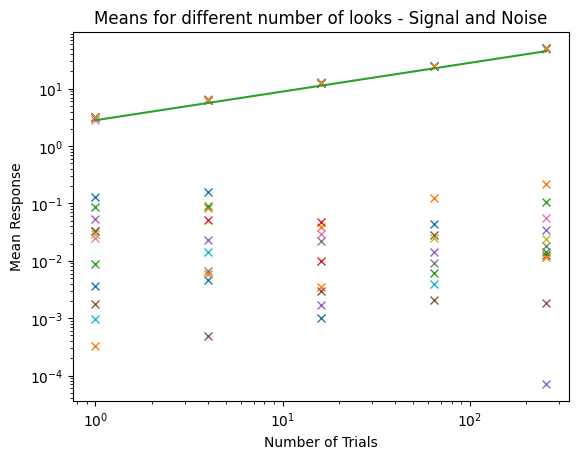

In [198]:
# spml_var_signal is size num_signal_levels x num_trials
plt.loglog(num_look_list, [spml_mean_noise [nl][-1, :] for nl in num_look_list],'x')
plt.loglog(num_look_list, [spml_mean_signal[nl][-1, :] for nl in num_look_list],'x')
plt.loglog(num_look_list, 2.828*np.asarray(num_look_list)**0.5, '-')
plt.ylabel('Mean Response')
plt.xlabel('Number of Trials')
plt.title('Means for different number of looks - Signal and Noise');

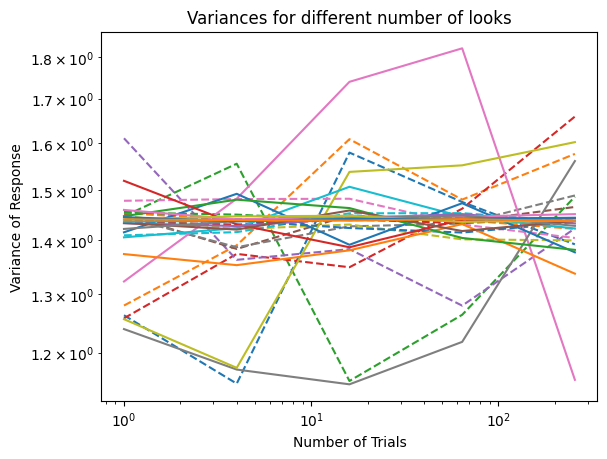

In [175]:
# spml_var_signal is size num_signal_levels x num_trials
plt.loglog(num_look_list, [spml_var_noise[nl][-1, :] for nl in num_look_list], '--')
plt.loglog(num_look_list, [spml_var_signal[nl][-1, :] for nl in num_look_list])
plt.ylabel('Variance of Response')
plt.xlabel('Number of Trials');
plt.title('Variances for different number of looks');

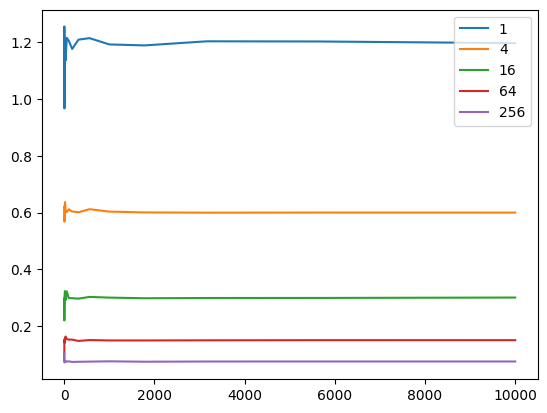

In [176]:
for num_looks in num_look_list:
    plt.plot(correlation_trial_count_list, spml_interpolated[num_looks], label=num_looks)
plt.legend();

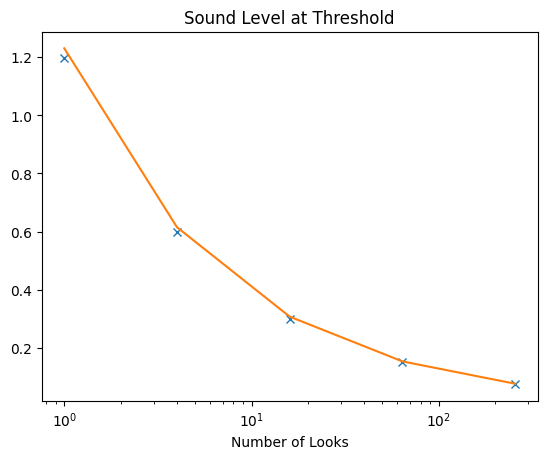

In [188]:
plt.semilogx(num_look_list, [spml_interpolated[nl][-1] for nl in num_look_list], 'x')
plt.semilogx(num_look_list, 1.23*np.asarray(num_look_list)**(-0.5), '-')
plt.title('Sound Level at Threshold')
plt.xlabel('Number of Looks');

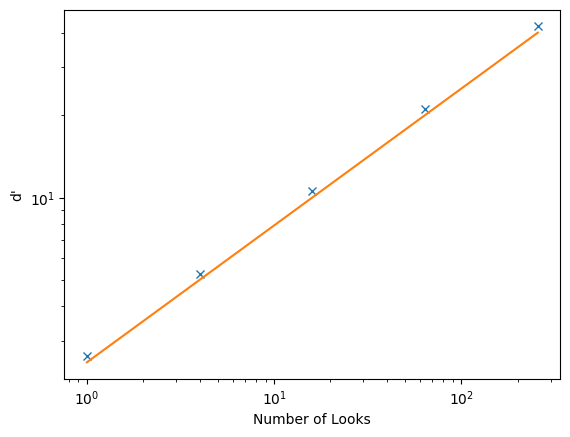

In [187]:
# dprimes is size num_signal_levels x num_trials
plt.loglog(num_look_list, [spml_dprimes[nl][-1, -1] for nl in num_look_list], 'x')
plt.loglog(num_look_list, 2.5*np.asarray(num_look_list)**0.5, '-')
plt.ylabel('d\'')
plt.xlabel('Number of Looks');

## Multilook Explanation

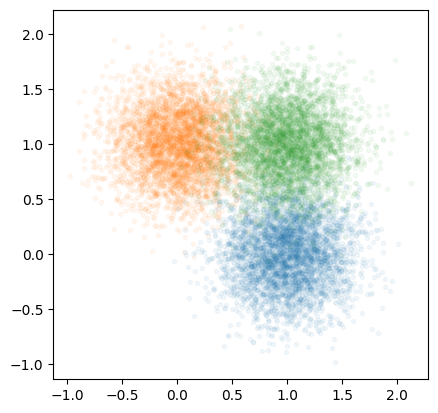

In [215]:
# Make a plot show how muliple looks are used.
def gaussian_scatter(center=(0, 0), r=0.3, count=100) -> NDArray:
  points = np.random.randn(len(center), count)*r
  return points + np.expand_dims(np.asarray(center), axis=1)

count = 4000
points0 = gaussian_scatter(center=(1, 0), r=0.3, count=count)
points1 = gaussian_scatter(center=(0, 1), r=0.3, count=count)
points2 = gaussian_scatter(center=(1, 1), r=0.3, count=count)
alpha = 0.05
plt.plot(points0[0, :], points0[1, :], '.', alpha=alpha)
plt.plot(points1[0, :], points1[1, :], '.', alpha=alpha)
plt.plot(points2[0, :], points2[1, :], '.', alpha=alpha)
plt.gca().set_aspect('equal', adjustable='box');

In [216]:
h0 = gaussian_scatter(center=[0], r=0.3, count=1000)
h1 = gaussian_scatter(center=[1], r=0.3, count=1000)
h0.shape

(1, 1000)

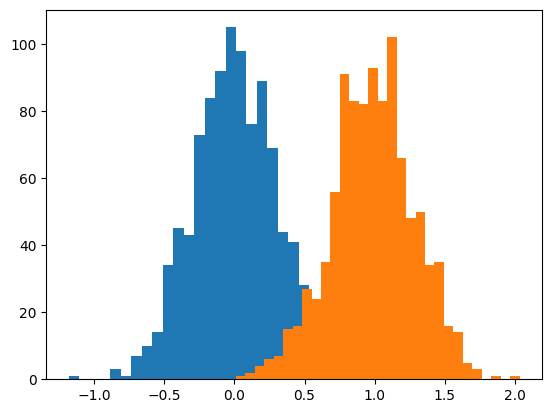

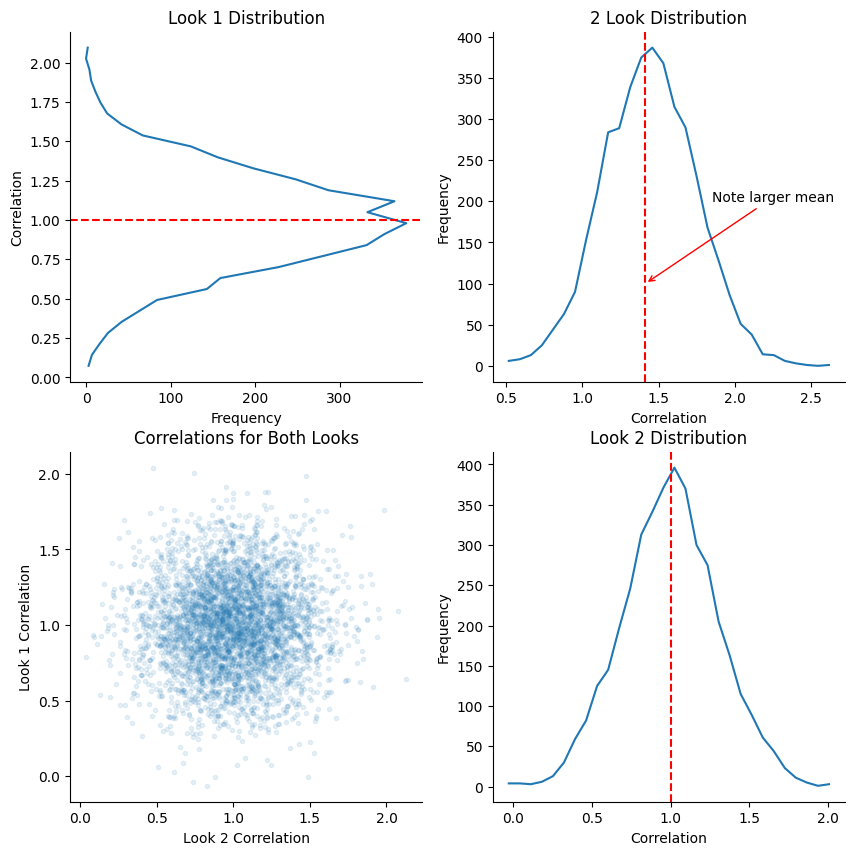

In [217]:
plt.hist(h0.reshape((-1,)), bins=30, label='H0',)
plt.hist(h1.reshape((-1,)), bins=30, label='H1');

plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
counts, centers = np.histogram(points2[0,:], bins=30)
plt.plot(counts, (centers[1:] + centers[:-1])/2);
plt.xlabel('Frequency'), plt.ylabel('Correlation'), plt.title('Look 1 Distribution')
plt.axhline(1.0, ls='--', color='r')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)


plt.subplot(2, 2, 3)
plt.plot(points2[0, :], points2[1, :], '.', alpha=0.1)
plt.title('Correlations for Both Looks')
plt.xlabel('Look 2 Correlation'), plt.ylabel('Look 1 Correlation')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.subplot(2, 2, 2)
distance = np.sqrt(points2[0, :]**2 + points2[1, :]**2)
counts, centers = np.histogram(distance, bins=30)
plt.plot((centers[1:] + centers[:-1])/2, counts)
plt.axvline(np.sqrt(2), ls='--', color='r')
plt.ylabel('Frequency'), plt.xlabel('Correlation'), plt.title('2 Look Distribution')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.annotate('Note larger mean', (1.414, 100), (1.85, 200),
             arrowprops=dict(arrowstyle='->', color='red'))

plt.subplot(2, 2, 4)
counts, centers = np.histogram(points2[1,:], bins=30)
plt.plot((centers[1:] + centers[:-1])/2, counts)
plt.axvline(1.0, ls='--', color='r');
plt.ylabel('Frequency'), plt.xlabel('Correlation'), plt.title('Look 2 Distribution');
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

In [218]:
# Make a plot show how muliple looks are used.
def gaussian_scatter(center=(0, 0), r=0.3, count=100) -> NDArray:
  points = np.random.randn(len(center), count)*r
  return points + np.expand_dims(np.asarray(center), axis=1)

count = 4000

noise_points = gaussian_scatter(center=(0, 0), r=0.3, count=count)
signal_points = gaussian_scatter(center=(1, 1), r=0.3, count=count)

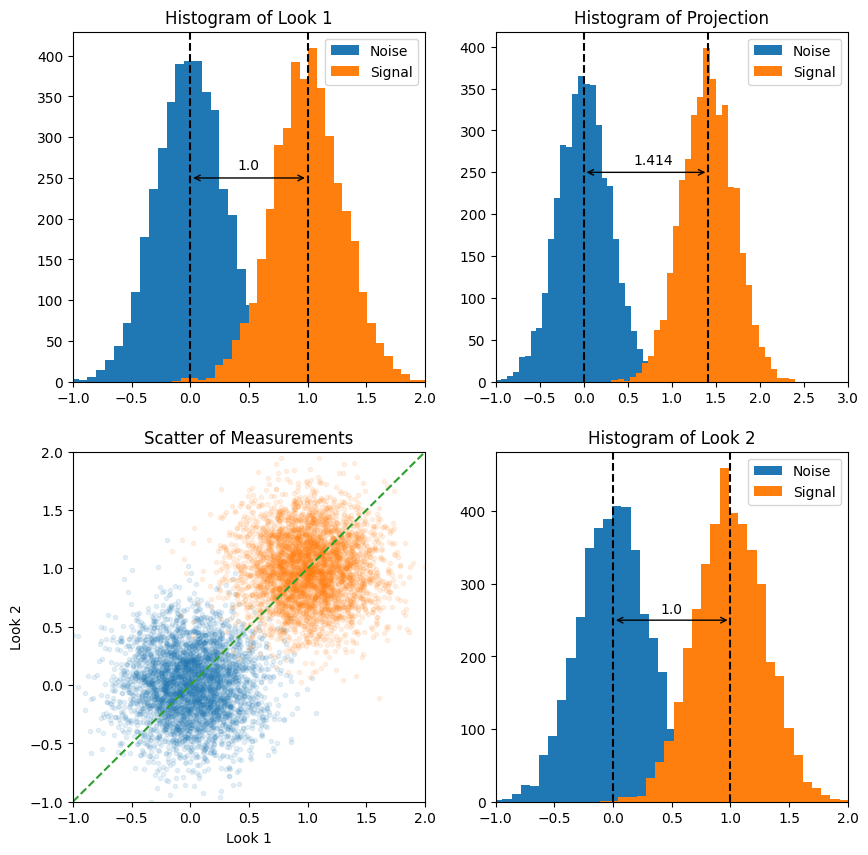

In [220]:
alpha = 0.1

def show_dist(second_mean, label: str = '', y=250, color='k', ):
  plt.axvline(0, ls='--', color=color)
  plt.axvline(second_mean, ls='--', color=color)
  plt.annotate("", (0, y), (second_mean, y), 
                    arrowprops=dict(arrowstyle="<->", color='black'))
  plt.text(0.4*second_mean, y+10, label)

plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
plt.hist(noise_points[0, :], bins=30, label='Noise')
plt.hist(signal_points[0, :], bins=30, label='Signal')
plt.xlim(-1, 2)
show_dist(1, '1.0')
plt.legend()
plt.title('Histogram of Look 1')

plt.subplot(2, 2, 2)
projector = np.ones((2, count))/np.sqrt(2)
noise_projection = np.sum(noise_points * projector, axis=0)
signal_projection = np.sum(signal_points * projector, axis=0)
plt.hist(noise_projection, bins=30, label='Noise')
plt.hist(signal_projection, bins=30, label='Signal')
plt.xlim(-1, 3)
show_dist(np.sqrt(2), '1.414')
plt.legend()
plt.title('Histogram of Projection')

plt.subplot(2, 2, 3)
plt.plot(noise_points[0, :], noise_points[1, :], '.', alpha=alpha)
plt.plot(signal_points[0, :], signal_points[1, :], '.', alpha=alpha);
plt.plot([-1, 2], [-1, 2], '--')
plt.xlim(-1, 2)
plt.ylim(-1, 2)
plt.xlabel('Look 1')
plt.ylabel('Look 2')
plt.title('Scatter of Measurements')

plt.subplot(2, 2, 4)
plt.hist(noise_points[1, :], bins=30, label='Noise')
plt.hist(signal_points[1, :], bins=30, label='Signal')
plt.xlim(-1, 2)
show_dist(1, '1.0')
plt.legend();
plt.title('Histogram of Look 2');

plt.savefig('MultiLook_Histograms.png')

## Gammatone Power/Threshold Plot

In [26]:
# Create the single Gammatone we use for this rest of this study.
sample_rate = 8000
gt = create_synthetic_stack(noise_level=0, num_times=100, num_trials=1,
                           bw=200, order=4, cf=1000, signal_levels=(1,),
                           sample_rate=sample_rate)
gt = np.squeeze(gt)
plt.plot(np.arange(len(gt))/sample_rate, gt)
gt.shape

# Create a bunch of noise, of amplitude 1, and find the average signal
# (via cumsum) for all the different trial counts. Then compute the power
# (in the average of the responses) as a function of the number of trials.
power_num_trials_list = [int(i) for i in 10**np.arange(0.0, 5.2, 0.125)]

max_trial_count = power_num_trials_list[-1]
num_experiments = 110
# Compute the culumative mean power of the noise, divided by the trial count
mean_noise = np.cumsum(np.random.randn(len(gt), max_trial_count, num_experiments),
                       axis=1) / np.expand_dims(np.arange(1, max_trial_count + 1),
                                                axis=[0, 2])
# Average over time
noise_power = np.mean(mean_noise**2, axis=0) # num_samples x num_experiments

mean_noise.shape
# num_times, num_trials, num_exps

plt.loglog(noise_power)
plt.xlabel('Number of Trials (N)')
plt.ylabel('Noise Power')
plt.title('Checking Noise Power Changes with Trial Count')

# Power in noise term goes down by N (so amplitude decays by sqrt(N))
plt.plot([power_num_trials_list[0], power_num_trials_list[-1]],
         [2, 2/(power_num_trials_list[-1])], '--');

We calculate the power ratio (signal power / noise power) by assuming that the noise and signal powers add.

> threshold = (gammatone_power * s^2 + n^2 ) / n^2

Solve for s that will lead to the desired threshold

>


# For the desired *amplitude* threshold, 2x the average noise amplitude
desired_power_threshold = 2
gt_power = np.mean(gt**2) # Average over time
power_threshold_level = []
for num_trials in power_num_trials_list:
  s = np.sqrt((desired_power_threshold-1) * noise_power[num_trials-1, 0]/gt_power)
  power_threshold_level.append(s)

plt.loglog(power_num_trials_list, power_threshold_level, label='power')
plt.title(f'Threshold vs Trials (power ratio threshold is {desired_power_threshold}x)')
plt.xlabel('Number of Trials')
plt.ylabel('Sound Level at Threshold (a.u.)');

plt.plot([power_num_trials_list[0], power_num_trials_list[-1]],
         [2, 2/np.sqrt(power_num_trials_list[-1])], '--',
         label='sqrt(N) line')
plt.legend();

# Amplitude means
noise_amps = np.sqrt(noise_power) # num_trials x num_experiments
signal_amps = np.sqrt(gt_power + noise_power)

noise_means = np.mean(noise_amps, axis=1) # Average over exps (by trial #)
signal_means = np.mean(signal_amps, axis=1)

noise_vars = np.var(noise_amps, axis=1) # variance of exps (by trial #)
signal_vars = np.var(signal_amps, axis=1)

amplitude_dprimes = (signal_means - noise_means)/np.sqrt(signal_vars + noise_vars/2)
plt.loglog(np.arange(max_trial_count)+1, amplitude_dprimes)
plt.xlabel('Number of Trials')
plt.ylabel('d\'')
plt.axhline(y=desired_power_threshold, color='r', linestyle='--')
plt.title('Amplitude Distribution d\'');
# Oh yeah, the signal contributes nothing to the variance, as it is constant.
# so we asymptote as the signal level gets smaller.
plt.plot([1, max_trial_count+1], [6*1, 6*np.sqrt(max_trial_count+1)],
         ':');

plt.errorbar(1+np.arange(len(signal_means[::100])), signal_means[::100],
             yerr=np.sqrt(signal_vars[::100]), label='Signal power')
plt.errorbar(1+np.arange(len(noise_means[::100])), noise_means[::100],
             yerr=np.sqrt(noise_vars[::100]), label='Noise power')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of Trials')
plt.ylabel('Power')
plt.title('Signal Mean vs. Trials with Variance');

plt.loglog(1+np.arange(len(noise_vars)), noise_vars, label='Noise')
plt.loglog(1+np.arange(len(signal_vars)), signal_vars, label='Signal')
plt.legend()
plt.title('Amplitude Variances');

##Multi-look correlation measure

signal_levels = 10**np.arange(-3, 0.26, .25)

correlation_trial_count_list = [1, 2, 10]
correlation_trial_count_list = [int(f) for f in 10**np.arange(0, 4.1, 0.25)]

num_experiments = 200
expanded_gt = np.expand_dims(gt, axis=[1, 2])
dprimes = np.zeros((len(signal_levels), len(correlation_trial_count_list)))
for i, s in enumerate(signal_levels):
  for j, trial_count in enumerate(correlation_trial_count_list):
    noise = np.random.randn(len(gt), trial_count, num_experiments)
    measurements = noise + s * expanded_gt  # The measured ABR signals

    # Now compute the correlations against the model, average across time.
    noise_correlations = np.mean(noise * expanded_gt, axis=0)
    signal_correlations = np.mean(measurements * expanded_gt, axis=0)
    assert signal_correlations.shape == noise_correlations.shape == (trial_count, num_experiments)

    # Now compute RMS over each group of looks.
    noise_distances = np.sqrt(np.mean(noise_correlations ** 2, axis=0))
    signal_distances = np.sqrt(np.mean(signal_correlations ** 2, axis=0))
    assert signal_distances.shape == (num_experiments,)

    # Compute d' across the group of experiments.
    dprimes[i, j] = (np.mean(signal_distances)-np.mean(noise_distances))/(
        np.sqrt(np.var(signal_distances)+np.var(noise_distances)/2))

plt.loglog(correlation_trial_count_list, dprimes[12, :], label='Gammatone')
plt.xlabel('Number of Looks (N)')
plt.ylabel('d\'');
plt.title('Correlation d\' Versus the Number of Looks')

# Lay a line over the top
plt.plot([correlation_trial_count_list[0], correlation_trial_count_list[-1]],
          [2*np.sqrt(correlation_trial_count_list[0]), 2*np.sqrt(correlation_trial_count_list[-1])],
         '--', label='Proportional to sqrt(N)')
plt.legend();

dprimes

plt.semilogy(signal_levels, dprimes);
plt.legend(correlation_trial_count_list)
plt.xlabel('Signal Level (a.u.)')
plt.ylabel('d\'')
plt.axhline(y=1, color='r', linestyle='--')
plt.title('Correlation Metric vs. Sound Level and Number of Looks');



correlation_threshold = 1 # What d' do we want for threshold?
crossing_points_interpolated = []

for j in range(dprimes.shape[1]):
  # Create an interpolation function for the current trial count's dprimes
  interp_func = interp1d(dprimes[:, j], signal_levels, kind='linear')

  # Find the signal level at the threshold using the interpolation function
  try:
    signal_level_at_threshold = interp_func(correlation_threshold)
    crossing_points_interpolated.append(signal_level_at_threshold)
  except ValueError:
    # If the threshold is outside the range of dprimes, append NaN
    crossing_points_interpolated.append(np.nan)


print(f"Signal level at which d' crosses the threshold (d'={correlation_threshold}) for each trial count (interpolated):")
for j, trial_count in enumerate(correlation_trial_count_list):
  print(f"Trial count {trial_count}: {crossing_points_interpolated[j]:.4f}")

plt.semilogx(correlation_trial_count_list, crossing_points_interpolated)
plt.xlabel('Number of Trials')
plt.ylabel('Sound Level at Threshold (a.u.)')
plt.title(f'Correlation Threshold vs. Trials (d\' = {correlation_threshold})');

plt.loglog(power_num_trials_list, power_threshold_level, label='power')
plt.loglog(correlation_trial_count_list, crossing_points_interpolated, label='Correlation')
plt.xlabel('Number of Trials')
plt.ylabel('Sound Level at Threshold (a.u.)')
plt.title(f'Threshold vs. Trials')
plt.legend();

##Redo power results but calculate d' as a summary metric
Synthesize some data of shape
> Length of the gt x trial_count x num_experiments

Then compute the correlation and power distances, and distributions.

Assume we have the model for the correlation.

def simulated_exp(gt, trial_count, num_experiments, s, estimate_model=False):
  noise = np.random.randn(len(gt), trial_count, num_experiments)
  expanded_gt = np.expand_dims(gt, axis=[1, 2])
  measurements = noise + s * expanded_gt  # The measured ABR signals

  if estimate_model:
    matched_filter = np.mean(measurements, axis=1, keepdims=True)
  else:
    matched_filter = expanded_gt

  # Now compute the correlations against the (ideal) model, average across time.
  noise_correlations = np.mean(noise * matched_filter, axis=0)
  signal_correlations = np.mean(measurements * matched_filter, axis=0)
  assert signal_correlations.shape == noise_correlations.shape == (trial_count, num_experiments)

  # Now compute RMS distance over each group of looks.
  noise_distances = np.sqrt(np.mean(noise_correlations ** 2, axis=0)) # RMS over trials
  signal_distances = np.sqrt(np.mean(signal_correlations ** 2, axis=0))
  # noise_distances = np.mean(noise_correlations, axis=0) # Average over trials
  # signal_distances = np.mean(signal_correlations, axis=0)
  assert signal_distances.shape == (num_experiments,)

  # Compute d' across the group of experiments.
  cor_dprimes = (np.mean(signal_distances)-np.mean(noise_distances))/(
      np.sqrt(np.var(signal_distances)+np.var(noise_distances)/2))
  # cor_dprimes = (np.mean(signal_correlations)-np.mean(noise_correlations))/(
  #     np.sqrt(np.var(signal_correlations)+np.var(noise_correlations)/2))

  # Now compute the distribution for the power measure
  # Average over trials, then square to get power across time
  ave_noise = np.mean(noise, axis=1) # Ave over trials
  ave_signal = np.mean(measurements, axis=1) # Ave over trials
  noise_power_mean = np.mean(ave_noise**2, axis=0) # Ave over time
  noise_power_var = np.var(ave_noise**2, axis=0) # Ave over time
  signal_power_mean = np.mean(ave_signal**2, axis=0)
  signal_power_var = np.var(ave_signal**2, axis=0)
  power_dprimes = (np.mean(signal_power_mean)-np.mean(noise_power_mean))/(
      np.sqrt(np.var(signal_power_mean)+np.var(noise_power_mean)/2))
  return (cor_dprimes, power_dprimes,
          signal_distances, noise_distances,
          signal_power_mean, noise_power_mean)

def summarize_dists(signals, noises, bins=30):
  plt.hist(signals, bins=bins, label='Signal')
  plt.hist(noises, bins=bins, label='Noise')
  plt.legend()
  plt.axvline(np.mean(signals), color='r', linestyle='--')
  plt.axvline(np.mean(noises), color='b', linestyle='--')
  dprime = (np.mean(signals)-np.mean(noises)) / np.sqrt(np.var(signals)+np.var(noises)/2)

  xmin, xmax, ymin, ymax = plt.axis()
  y = ymin + (ymax-ymin)*0.8
  plt.annotate(f"d' = {dprime}", xy=(np.mean(noises), y), xytext=(np.mean(signals), y),
               arrowprops=dict(arrowstyle='<->'))

(cor_dprimes, power_dprimes, signal_distances, noise_distances,
 signal_power_mean, noise_power_mean) = simulated_exp(gt, trial_count=100,
                                                      num_experiments=2000, s=.15)

summarize_dists(signal_distances, noise_distances)
plt.title('Average Correlation Distributions');

summarize_dists(signal_power_mean, noise_power_mean)
plt.title('Average Power Distributions');

signal_levels = 10**np.arange(-3, 0.26, .25)

combined_trial_count_list = [1, 2, 10]
combined_trial_count_list = [int(f) for f in 10**np.arange(0, 4.1, 0.25)]

num_experiments = 200
expanded_gt = np.expand_dims(gt, axis=[1, 2])
cor_dprimes = np.zeros((len(signal_levels), len(correlation_trial_count_list)))
power_dprimes = np.zeros((len(signal_levels), len(correlation_trial_count_list)))
for i, s in enumerate(signal_levels):
  for j, trial_count in enumerate(correlation_trial_count_list):
    (cor_dprimes[i, j], power_dprimes[i, j],
     _, _, _, _) = simulated_exp(gt, trial_count=trial_count,
                                 num_experiments=num_experiments, s=s,
                                 estimate_model=False)

plt.loglog(signal_levels, cor_dprimes)
plt.xlabel('Signal Levels (a.u.)')
plt.ylabel('d\'')
plt.title('Correlation d\' versus Signal Level and Trial Count')

correlation_threshold = 1 # What d' do we want for threshold?
plt.axhline(correlation_threshold, color='r', linestyle='--');
# Negative d' results lead to flakey downward lines below

plt.loglog(signal_levels, power_dprimes)
plt.xlabel('Signal Levels (a.u.)')
plt.ylabel('d\'');
plt.title('Power d\' versus Signal Level and Trial Count')

power_threshold = 1 # What d' do we want for threshold?
plt.axhline(power_threshold, color='r', linestyle='--');

# Negative d' results lead to flakey downward lines below

correlation_points_interpolated = []

for j in range(dprimes.shape[1]):
  # Create an interpolation function for the current trial count's dprimes
  interp_func = interp1d(cor_dprimes[:, j], signal_levels, kind='linear')

  # Find the signal level at the threshold using the interpolation function
  try:
    signal_level_at_threshold = interp_func(correlation_threshold)
    correlation_points_interpolated.append(signal_level_at_threshold)
  except ValueError:
    # If the threshold is outside the range of dprimes, append NaN
    correlation_points_interpolated.append(np.nan)


print(f"Signal level at which d' crosses the threshold (d'={correlation_threshold}) for each trial count (interpolated):")
for j, trial_count in enumerate(correlation_trial_count_list):
  print(f"Trial count {trial_count}: {correlation_points_interpolated[j]:.4f}")

power_points_interpolated = []

for j in range(power_dprimes.shape[1]):
  # Create an interpolation function for the current trial count's dprimes
  interp_func = interp1d(power_dprimes[:, j], signal_levels, kind='linear')

  # Find the signal level at the threshold using the interpolation function
  try:
    signal_level_at_threshold = interp_func(power_threshold)
    power_points_interpolated.append(signal_level_at_threshold)
  except ValueError:
    # If the threshold is outside the range of dprimes, append NaN
    power_points_interpolated.append(np.nan)


print(f"Signal level at which d' crosses the threshold (d'={power_threshold}) for each trial count (interpolated):")
for j, trial_count in enumerate(power_points_interpolated):
  print(f"Trial count {trial_count}: {power_points_interpolated[j]:.4f}")

plt.loglog(correlation_trial_count_list, power_points_interpolated, label='power')
plt.loglog(correlation_trial_count_list, correlation_points_interpolated, label='Correlation')
plt.xlabel('Number of Trials')
plt.ylabel('Sound Level at Threshold (a.u.)')
plt.title(f'Threshold vs. Trials')

plt.plot([correlation_trial_count_list[0], correlation_trial_count_list[-1]],
         [1.5, 1.5*correlation_trial_count_list[-1]**-0.5], '--',
         label='$\\sqrt{N}$')
plt.plot([correlation_trial_count_list[0], correlation_trial_count_list[-1]],
         [0.4, 0.4*correlation_trial_count_list[-1]**-0.25], '--',
         label='$N^{-0.25}$')

plt.legend();

N = correlation_trial_count_list
s = signal_levels
n = default_noise_level

predicted_power_dprimes = signal_levels**2 / (
    np.sqrt(2*signal_levels**2)
)

##Graphical Images for Explanation

# Make a plot show how muliple looks are used.
def gaussian_scatter(center=(0, 0), r=0.3, count=100) -> NDArray:
  points = np.random.randn(len(center), count)*r
  return points + np.expand_dims(np.asarray(center), axis=1)

count = 4000
points0 = gaussian_scatter(center=(1, 0), r=0.3, count=count)
points1 = gaussian_scatter(center=(0, 1), r=0.3, count=count)
points2 = gaussian_scatter(center=(1, 1), r=0.3, count=count)
alpha = 0.05
plt.plot(points0[0, :], points0[1, :], '.', alpha=alpha)
plt.plot(points1[0, :], points1[1, :], '.', alpha=alpha)
plt.plot(points2[0, :], points2[1, :], '.', alpha=alpha)
plt.gca().set_aspect('equal', adjustable='box');

h0 = gaussian_scatter(center=[0], r=0.3, count=1000)
h1 = gaussian_scatter(center=[1], r=0.3, count=1000)
h0.shape

plt.hist(h0.reshape((-1,)), bins=30, label='H0',)
plt.hist(h1.reshape((-1,)), bins=30, label='H1');

plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
counts, centers = np.histogram(points2[0,:], bins=30)
plt.plot(counts, (centers[1:] + centers[:-1])/2);
plt.xlabel('Frequency'), plt.ylabel('Correlation'), plt.title('Look 1 Distribution')
plt.axhline(1.0, ls='--', color='r')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)


plt.subplot(2, 2, 3)
plt.plot(points2[0, :], points2[1, :], '.', alpha=0.1)
plt.title('Correlations for Both Looks')
plt.xlabel('Look 2 Correlation'), plt.ylabel('Look 1 Correlation')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.subplot(2, 2, 2)
distance = np.sqrt(points2[0, :]**2 + points2[1, :]**2)
counts, centers = np.histogram(distance, bins=30)
plt.plot((centers[1:] + centers[:-1])/2, counts)
plt.axvline(np.sqrt(2), ls='--', color='r')
plt.ylabel('Frequency'), plt.xlabel('Correlation'), plt.title('2 Look Distribution')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.subplot(2, 2, 4)
counts, centers = np.histogram(points2[1,:], bins=30)
plt.plot((centers[1:] + centers[:-1])/2, counts)
plt.axvline(1.0, ls='--', color='r');
plt.ylabel('Frequency'), plt.xlabel('Correlation'), plt.title('Look 2 Distribution');
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)


SyntaxError: invalid syntax (2895168597.py, line 36)